In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array

# Ścieżki

In [2]:
folder = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
folder_path = pathlib.Path(folder)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460 at 0x7D8D6C818590>


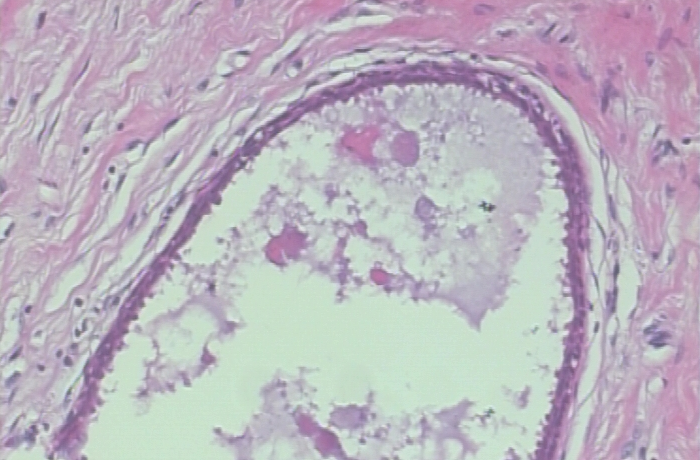

In [3]:
photo = load_img('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png')
print(photo)
photo

# rozmiar + parametry augmentacji

In [4]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

# augmentacja

In [5]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 7909 images belonging to 2 classes.


In [6]:
train_data, train_labels = train_data_gen.next()

# wyrównanie zbioru złośliwego i łagodnego

In [7]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(8040, 49152) (8040, 1)


# sprowadzenie obrazów po augmentacji i funkcji SMOTE do dobrych wymiarów

In [8]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(8040, 128, 128, 3) (8040, 1)


In [9]:
train_labels = train_labels.reshape(-1, 1)

# podział na testowy i treningowy

20% to testowy, reszta treningowy (z czego 20% to walidacyjny)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
tf.keras.backend.set_image_data_format('channels_first')

# Budowa modelu

In [13]:
from keras import backend as K

K.set_image_data_format('channels_last')
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [14]:
for layer in vgg_model.layers:
    layer.trainable = False

In [15]:
vgg16_model = Sequential([
    vgg_model,
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')        
], name="vgg16_model")

In [16]:
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               

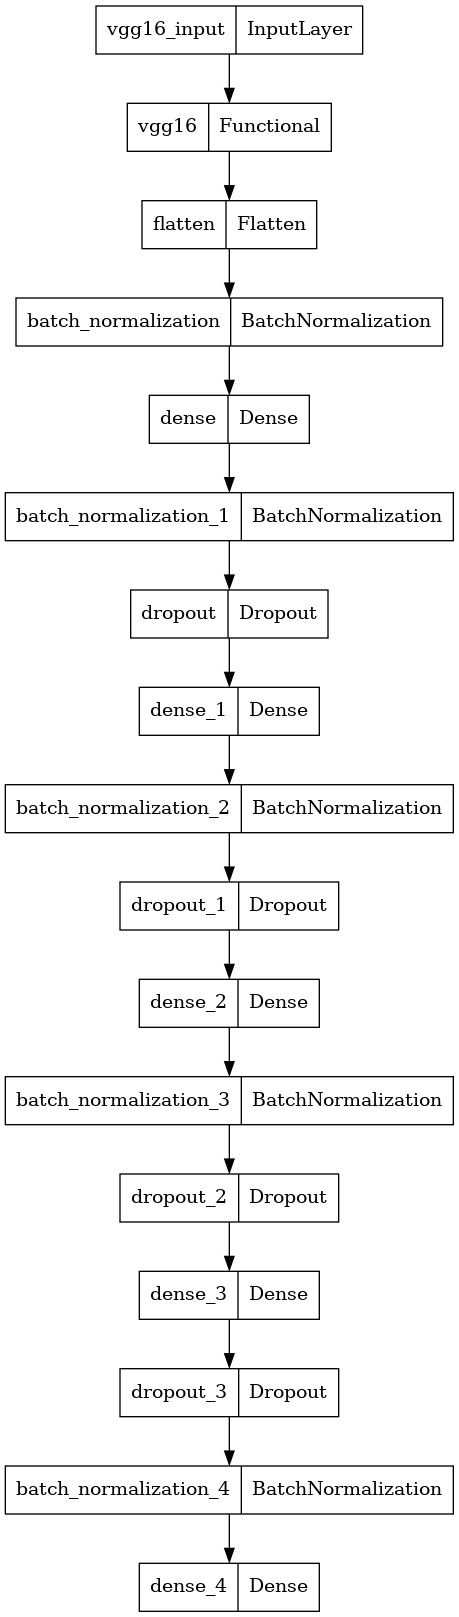

In [17]:
plot_model(vgg16_model)

# trenowanie modelu

In [18]:
vgg16_history = vgg16_model.fit(train_data, train_labels, epochs=50, verbose=1)

vgg16_accuracy_history = vgg16_history.history['accuracy']
vgg16_loss_history = vgg16_history.history['loss']

Epoch 1/50
161/161 [==============================] - 28s 54ms/step - loss: 0.7660 - accuracy: 0.5675
Epoch 2/50
161/161 [==============================] - 7s 42ms/step - loss: 0.5880 - accuracy: 0.6989
Epoch 3/50
161/161 [==============================] - 7s 43ms/step - loss: 0.4638 - accuracy: 0.7883
Epoch 4/50
161/161 [==============================] - 7s 42ms/step - loss: 0.3943 - accuracy: 0.8286
Epoch 5/50
161/161 [==============================] - 7s 42ms/step - loss: 0.3361 - accuracy: 0.8564
Epoch 6/50
161/161 [==============================] - 7s 43ms/step - loss: 0.3037 - accuracy: 0.8742
Epoch 7/50
161/161 [==============================] - 7s 43ms/step - loss: 0.2597 - accuracy: 0.8937
Epoch 8/50
161/161 [==============================] - 7s 43ms/step - loss: 0.2348 - accuracy: 0.9052
Epoch 9/50
161/161 [==============================] - 7s 43ms/step - loss: 0.2068 - accuracy: 0.9178
Epoch 10/50
161/161 [==============================] - 7s 43ms/step - loss: 0.1870 - accur

# statystyki modelu

In [19]:
loss, accuracy = vgg16_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 3s 59ms/step - loss: 0.5537 - accuracy: 0.8632
Accuracy: 86.32%


In [20]:
y_pred = np.round(vgg16_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

vgg16_precision = avg_precision
vgg16_recall = avg_recall
vgg16_f1score = avg_f1_score

51/51 [==============================] - 2s 42ms/step
Average Precision: 86.32%
Average Recall: 86.32%
Average F1 Score: 86.32%


51/51 [==============================] - 2s 40ms/step


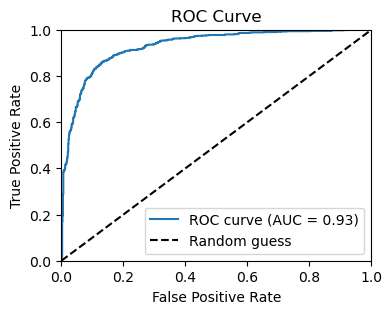

In [21]:
y_pred_prob_tl = vgg16_model.predict(test_data)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob_tl)

roc_auc = roc_auc_score(test_labels, y_pred_prob_tl)

plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

51/51 [==============================] - 2s 40ms/step


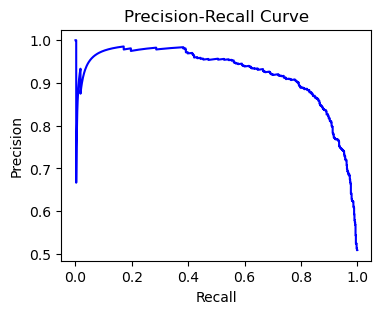

In [22]:
y_scores = vgg16_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

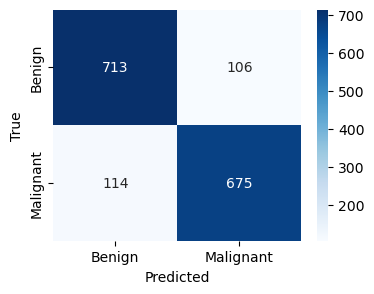

In [23]:
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Ewaluacja modelu

51/51 [==============================] - 2s 41ms/step - loss: 0.5537 - accuracy: 0.8632


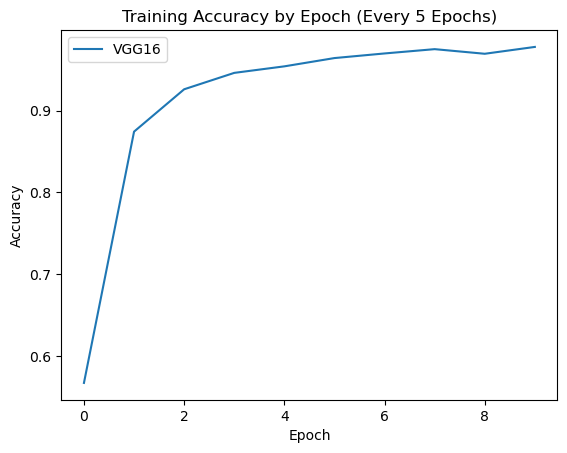

In [24]:
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(test_data, test_labels)
vgg16_history = vgg16_accuracy_history[::5]

plt.plot(vgg16_history, label='VGG16')

plt.title('Training Accuracy by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

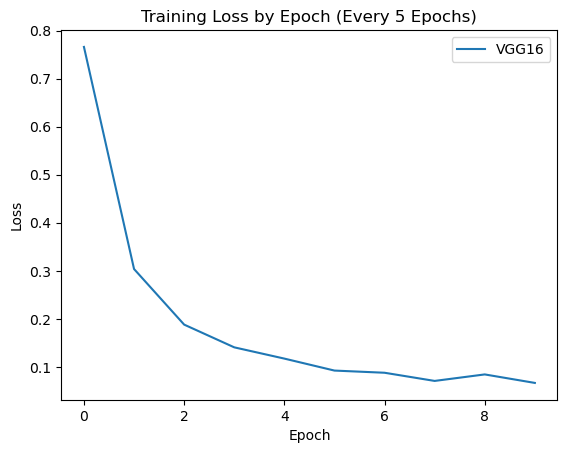

In [25]:
vgg16_history = vgg16_loss_history[::5]
plt.plot(vgg16_history, label='VGG16')
plt.title('Training Loss by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n01930112', 'nematode', 7.1893406)]


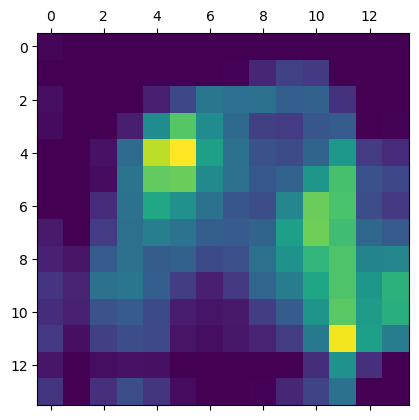

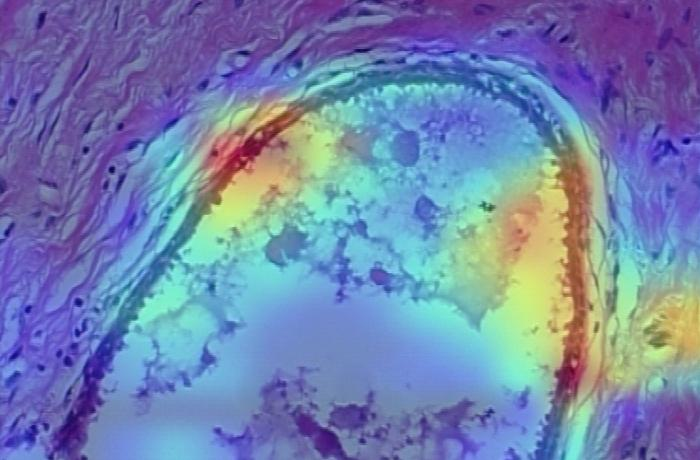

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name = 'block5_conv3'

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prepare image
img_path = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")
model.layers[-1].activation = None

# Print top predicted class
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

save_and_display_gradcam(img_path, heatmap)
